<a href="https://colab.research.google.com/github/filmerxyz/Skin_Detection/blob/master/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [1]:
!pip install tensorflow-gpu==1.15
!pip install split-folders
!pip install Augmentor

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 3.8MB 32.7MB/s 
     |████████████████████████████████| 512kB 60.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=960cad026f8196a5c3c914c581f211a8b62d0ee604cab29310f54a7c9b845473
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc1 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc1 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorf

In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

1.15.0


# Import Libraries

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras.applications.nasnet import decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.framework import ops

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import itertools

import split_folders
import Augmentor

import numpy as np
import matplotlib.pyplot as plt

import cv2

import os
from os.path import join
import glob
import shutil
import random

import json
from IPython.display import Image, display

# Clone Data

In [5]:
!git clone https://github.com/filmerxyz/SKIN_DATA

Cloning into 'SKIN_DATA'...
remote: Enumerating objects: 488, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 930 (delta 222), reused 398 (delta 134), pack-reused 442
Receiving objects: 100% (930/930), 113.50 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Checking out files: 100% (1818/1818), done.


# Define Functions

**Make a Directory**

In [0]:
def mkdir_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
        print("Directory " , dir,  " Created ")
    else:    
        print("Directory " , dir,  " already exists")

**Plot Images**

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

**Confusion Matrix**

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(img_height, img_width))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

In [0]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [0]:
def decode_predictions(preds, top=5, class_list_path='/content/SKIN_DATA/skin_index.json'): #'/content/SKIN_DATA/skin_index.json'
  if len(preds.shape) != 2 or preds.shape[1] != 4:
    raise ValueError('`decode_predictions` expects '
                     'a batch of predictions '
                     '(i.e. a 2D array of shape (samples, 1000)). '
                     'Found array with shape: ' + str(preds.shape))
  index_list = json.load(open(class_list_path))
  results = []
  for pred in preds:
    top_indices = pred.argsort()[-top:][::-1]
    result = [tuple(index_list[str(i)]) + (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[2], reverse=True)
    results.append(result)
  return results

**Guided Backprop**

In [0]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

**Grad CAM**

In [0]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (img_width, img_height), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], img_height, img_width))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (W, H), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

**

In [0]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = decode_predictions(np.eye(1, 4, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

# Make a Folder

In [16]:
mkdir_dir('/content/data_folder')

Directory  /content/data_folder  Created 


# Split Data

In [17]:
split_folders.ratio('/content/SKIN_DATA/crop_classes_data', 
                    output='/content/data_folder', 
                    seed=1337, 
                    ratio=(0.8, 0.1, 0.1)) #train=0.8, val=0.1, test=0.1

Copying files: 224 files [00:00, 2325.60 files/s]


# Directories

In [0]:
train_dir = '/content/data_folder/train'
val_dir = '/content/data_folder/val'
test_dir = '/content/data_folder/test'

# Data Visualization

In [0]:
ad_dir = '/content/data_folder/train/AtopicDermatitis'
pv_dir = '/content/data_folder/train/PsoriasisVulgaris'
sk_dir = '/content/data_folder/train/SeborrhoeicKeratosis'
vt_dir = '/content/data_folder/train/Vitiligo'

In [0]:
# plotImages(val_dir[:5])

# Parameters

In [0]:
img_width = 224
img_height = 224
epochs = 3
batch_size = 32

# Data Augmentation

In [0]:
root_directory = '/content/data_folder/train/*'

In [23]:
folders = []
for f in glob.glob(root_directory):
    if os.path.isdir(f):
        folders.append(os.path.abspath(f))

print("Folders (classes) found: %s " % [os.path.split(x)[1] for x in folders])

Folders (classes) found: ['AtopicDermatitis', 'PsoriasisVulgaris', 'Vitiligo', 'SeborrhoeicKeratosis'] 


In [24]:
pipelines = {}
for folder in folders:
    print("Folder %s:" % (folder))
    pipelines[os.path.split(folder)[1]] = (Augmentor.Pipeline(folder))
    print("\n----------------------------\n")

Folder /content/data_folder/train/AtopicDermatitis:
Initialised with 52 image(s) found.
Output directory set to /content/data_folder/train/AtopicDermatitis/output.
----------------------------

Folder /content/data_folder/train/PsoriasisVulgaris:
Initialised with 62 image(s) found.
Output directory set to /content/data_folder/train/PsoriasisVulgaris/output.
----------------------------

Folder /content/data_folder/train/Vitiligo:
Initialised with 19 image(s) found.
Output directory set to /content/data_folder/train/Vitiligo/output.
----------------------------

Folder /content/data_folder/train/SeborrhoeicKeratosis:
Initialised with 45 image(s) found.
Output directory set to /content/data_folder/train/SeborrhoeicKeratosis/output.
----------------------------



In [25]:
for p in pipelines.values():
    print("Class %s has %s samples." % (p.augmentor_images[0].class_label, len(p.augmentor_images)))

Class AtopicDermatitis has 52 samples.
Class PsoriasisVulgaris has 62 samples.
Class Vitiligo has 19 samples.
Class SeborrhoeicKeratosis has 45 samples.


In [26]:
for train_aug in pipelines.values():
    train_aug.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
    train_aug.flip_left_right(probability=0.5)
    train_aug.flip_top_bottom(probability=0.5)
    train_aug.zoom_random(probability=0.5, percentage_area=0.8)
    #train_aug.status()
    train_aug.sample(300)

Processing <PIL.Image.Image image mode=RGB size=550x324 at 0x7F78D1D534E0>: 100%|██████████| 300/300 [00:13<00:00, 22.18 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=243x326 at 0x7F78D1D7A080>: 100%|██████████| 300/300 [00:12<00:00, 24.21 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=480x267 at 0x7F78D1DB7080>: 100%|██████████| 300/300 [00:14<00:00, 21.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1640x1122 at 0x7F78D1DB44E0>: 100%|██████████| 300/300 [01:05<00:00,  4.59 Samples/s]


# Rename Folders

In [0]:
ad_aug_dir = os.rename('/content/data_folder/train/AtopicDermatitis/output', '/content/data_folder/train/AtopicDermatitis/ad_aug_dir')
pv_aug_dir = os.rename('/content/data_folder/train/PsoriasisVulgaris/output', '/content/data_folder/train/PsoriasisVulgaris/pv_aug_dir')
sk_aug_dir = os.rename('/content/data_folder/train/SeborrhoeicKeratosis/output', '/content/data_folder/train/SeborrhoeicKeratosis/sk_aug_dir')
vt_aug_dir = os.rename('/content/data_folder/train/Vitiligo/output', '/content/data_folder/train/Vitiligo/vt_aug_dir')

In [0]:
ad_aug_dir = '/content/data_folder/train/AtopicDermatitis/ad_aug_dir'
pv_aug_dir = '/content/data_folder/train/PsoriasisVulgaris/pv_aug_dir'
sk_aug_dir = '/content/data_folder/train/SeborrhoeicKeratosis/sk_aug_dir'
vt_aug_dir = '/content/data_folder/train/Vitiligo/vt_aug_dir'

In [0]:
# print(len(os.listdir(ad_aug_dir)))
# print(len(os.listdir(pv_aug_dir)))
# print(len(os.listdir(sk_aug_dir)))
# print(len(os.listdir(vt_aug_dir)))

In [30]:
mkdir_dir('/content/data_folder/train_aug')

Directory  /content/data_folder/train_aug  Created 


In [0]:
train_aug_dir = '/content/data_folder/train_aug/'

In [32]:
shutil.move(ad_aug_dir, train_aug_dir)
shutil.move(pv_aug_dir, train_aug_dir)
shutil.move(sk_aug_dir, train_aug_dir)
shutil.move(vt_aug_dir, train_aug_dir)

'/content/data_folder/train_aug/vt_aug_dir'

In [0]:
train_gen = ImageDataGenerator(rescale=1. / 255)

val_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = ImageDataGenerator(rescale=1. / 255)

In [34]:
train_datagen = train_gen.flow_from_directory(batch_size=batch_size,
                                          directory=train_aug_dir,
                                          shuffle=True,
                                          target_size=(img_width, img_height), #(224,224)
                                          class_mode='categorical')
val_datagen = val_gen.flow_from_directory(batch_size=batch_size,
                                          directory=val_dir,
                                          shuffle=True,
                                          target_size=(img_width, img_height), #(224,224)
                                          class_mode='categorical')
test_datagen = test_gen.flow_from_directory(batch_size=batch_size,
                                          directory=test_dir,
                                          shuffle=False,
                                          target_size=(img_width, img_height), #(224,224)
                                          class_mode='categorical')

Found 1200 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Found 26 images belonging to 4 classes.


In [0]:
# sample_training_images, _ = next(train_datagen)
# plotImages(sample_training_images[:5])

In [36]:
num_train_files = len(train_datagen.filenames)
num_train_classes = len(train_datagen.class_indices)
print('num_train_files', num_train_files, '&', 'num_train_classes', num_train_classes )

num_val_files = len(val_datagen.filenames)
num_val_classes = len(val_datagen.class_indices)
print('num_val_files', num_val_files, '&', 'num_val_classes', num_val_classes )

num_test_files = len(test_datagen.filenames)
num_test_classes = len(test_datagen.class_indices)
print('num_test_files', num_test_files, '&', 'num_test_classes', num_test_classes )

num_train_files 1200 & num_train_classes 4
num_val_files 20 & num_val_classes 4
num_test_files 26 & num_test_classes 4


In [0]:
train_steps = np.ceil(num_train_files/batch_size)
val_steps = np.ceil(num_val_files/batch_size)

# Model


In [0]:
def build_model():
  base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
  base_model.trainable = False
  # base_model.summary()
  # len(base_model.layers)
  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  prediction_layer = tf.keras.layers.Dense(units=4, activation='softmax', name='prediction')(average_pooling_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  # model.summary()
  # len(model.layers)
  return model

In [39]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
19996672/19993432 [==============================] - 3s 0us/step


# Compile

In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
#                              save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
cb_list = [early_stop]

# Train

In [44]:
history = model.fit(train_datagen,
                    steps_per_epoch=train_steps,
                    validation_data=val_datagen,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=cb_list)

Epoch 1/3
38/38 [==============================] - 28s 747ms/step - loss: 1.1012 - acc: 0.5358 - val_loss: 0.9976 - val_acc: 0.6000
Epoch 2/3
38/38 [==============================] - 10s 253ms/step - loss: 0.6514 - acc: 0.7858 - val_loss: 0.9023 - val_acc: 0.5500
Epoch 3/3
38/38 [==============================] - 12s 316ms/step - loss: 0.5112 - acc: 0.8483 - val_loss: 0.9883 - val_acc: 0.5500


# Google Drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# Graph

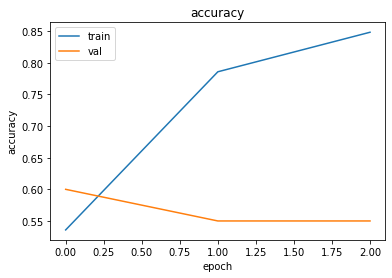

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

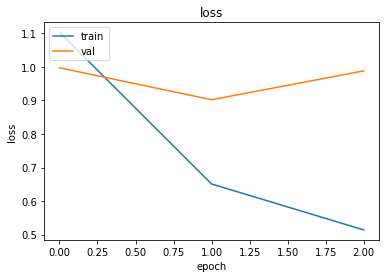

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Save Weights

In [0]:
model.save_weights('/content/skin_weights.h5')

In [0]:
skin_weights='/content/skin_weights.h5'

In [0]:
model.load_weights(skin_weights)

In [51]:
test_labels = test_datagen.classes
predictions = model.predict_generator(test_datagen, steps=val_steps, verbose=1)

1/1 [==============================] - 5s 5s/step


Confusion matrix, without normalization
[[5 1 0 1]
 [8 1 0 0]
 [1 0 6 0]
 [1 0 0 2]]


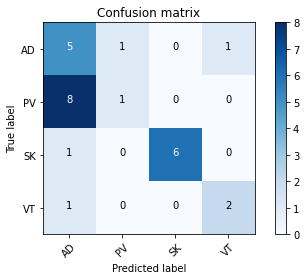

In [52]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['AD', 'PV', 'SK', 'VT']

plot_confusion_matrix(cm, cm_plot_labels)

In [0]:
# outputs = [layer.output for layer in model.layers[1:771]]

# layer_names = []
# for layer in outputs:
#     layer_names.append(layer.name.split("/")[0])

    
# print("Layers going to be used for visualization: ")
# print(layer_names)

# Classification Report

In [54]:
Y_pred = model.predict_generator(test_datagen, num_test_files//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_datagen.classes, y_pred))
print('Classification Report')
classes_names = ['AD', 'PV', 'SK', 'VT']
print(classification_report(test_datagen.classes, y_pred, target_names=classes_names))

Confusion Matrix
[[5 1 0 1]
 [8 1 0 0]
 [1 0 6 0]
 [1 0 0 2]]
Classification Report
              precision    recall  f1-score   support

          AD       0.33      0.71      0.45         7
          PV       0.50      0.11      0.18         9
          SK       1.00      0.86      0.92         7
          VT       0.67      0.67      0.67         3

    accuracy                           0.54        26
   macro avg       0.62      0.59      0.56        26
weighted avg       0.61      0.54      0.51        26



# Image

In [0]:
image_dir = '/content/data_folder/val'
img_paths = [join(image_dir, filename) for filename in 
               ['SeborrhoeicKeratosis/dq013406HB.jpg',
                'SeborrhoeicKeratosis/dq014959HB.jpg']]


In [0]:
H=224
W=224

In [0]:
def read_prep_images(img_paths, img_height=img_height, img_width=img_width):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return output

In [0]:
test_data = read_prep_images(img_paths)

In [0]:
preds = model.predict(test_data)

In [60]:
most_likely_labels = decode_predictions(preds, top=5, class_list_path='/content/SKIN_DATA/skin_index.json')

for i, img_path in enumerate(img_paths):
    # display(Image(img_path))
    print(most_likely_labels[i])

[('Atopic Dermatitis', 'AtopicDermatitis', 0.82265735), ('Vitiligo', 'Vitiligo', 0.12854509), ('Psoriasis Vulgaris', 'PsoriasisVulgaris', 0.042005543), ('Seborrhoeic Keratosis', 'SeborrhoeicKeratosis', 0.006792022)]
[('Atopic Dermatitis', 'AtopicDermatitis', 0.7940166), ('Psoriasis Vulgaris', 'PsoriasisVulgaris', 0.19570749), ('Vitiligo', 'Vitiligo', 0.010275425), ('Seborrhoeic Keratosis', 'SeborrhoeicKeratosis', 5.286299e-07)]


# Grad CAM

In [0]:
# model = build_model()
guided_model = build_guided_model()

In [0]:
x_img = '/content/SKIN_DATA/plan1_mix/model2/SeborrhoeicKeratosis/ABCD4.jpg'

Model prediction:
	AtopicDermatitis	(0)	with probability 1.000
	PsoriasisVulgaris	(1)	with probability 0.000
	Vitiligo       	(3)	with probability 0.000
	SeborrhoeicKeratosis	(2)	with probability 0.000
Explanation for 'AtopicDermatitis'


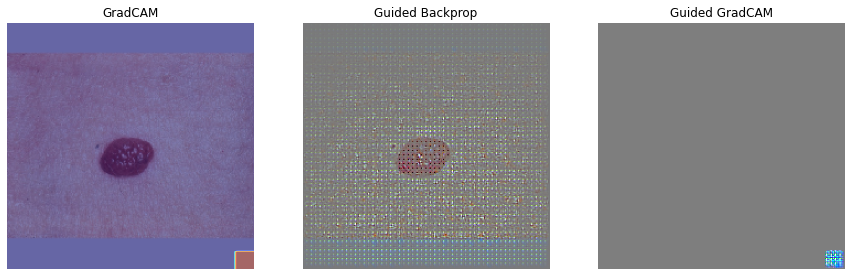

In [67]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, x_img, layer_name='normal_add_5_12', 
                                               cls=-1, visualize=True, save=True)

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, x_img, layer_name='normal_add_5_12',
                                               cls=3, visualize=True, save=False)